In [1]:
import string
import re
from pickle import load,dump
from unicodedata import normalize
from numpy import array
from numpy.random import rand
from numpy.random import shuffle
from numpy import argmax
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import optimizers
from tensorflow.keras.models import load_model
from nltk.translate.bleu_score import corpus_bleu
from nltk.translate.bleu_score import sentence_bleu
import pandas as pd
from tqdm import tqdm
import spacy

nlp = spacy.load('en_core_web_lg')
pd.set_option('display.max_colwidth', None)

In [2]:
df = pd.read_csv('fr.csv')

In [3]:
df.sample()

,Unnamed: 0,eng,fr,info
9263,9263,We're stuffed.,Nous sommes gavées.,CC-BY 2.0 (France) Attribution: tatoeba.org #2203413 (CK) & #4777318 (sacredceltic)


In [4]:
tqdm.pandas()
for c in ['eng', 'fr']:
    df.loc[:, str(c+'_clean')] = df.loc[:, c].str.replace('/', ' ')
    df.loc[:, str(c+'_clean')] = df.loc[:,str(c+'_clean')].str.replace('[ ][a-z][.]', ' ')
    df.loc[:, str(c+'_clean')] = df.loc[:, str(c+'_clean')].str.replace(r'[^\w\s]', ' ')
    df.loc[:, str(c+'_clean')] = df.loc[:, str(c+'_clean')].str.replace('\d+', ' ')
    df = df.astype(str)
    df[str(c+'_clean')] = df[str(c+'_clean')].str.lower()

C:\Users\Weronika Gramacka\AppData\Local\Temp\ipykernel_29324\3677572769.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  df.loc[:, str(c+'_clean')] = df.loc[:,str(c+'_clean')].str.replace('[ ][a-z][.]', ' ')
C:\Users\Weronika Gramacka\AppData\Local\Temp\ipykernel_29324\3677572769.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  df.loc[:, str(c+'_clean')] = df.loc[:, str(c+'_clean')].str.replace(r'[^\w\s]', ' ')
C:\Users\Weronika Gramacka\AppData\Local\Temp\ipykernel_29324\3677572769.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  df.loc[:, str(c+'_clean')] = df.loc[:, str(c+'_clean')].str.replace('\d+', ' ')
C:\Users\Weronika Gramacka\AppData\Local\Temp\ipykernel_29324\3677572769.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  df.loc[:, str(c+'_clean')] = df.loc[:,str(c+'_cl

In [5]:
df.sample(3)

,Unnamed: 0,eng,fr,info,eng_clean,fr_clean
172835,172835,All of us went to the theater to see a play.,Nous sommes tous allés au théâtre voir une pièce.,CC-BY 2.0 (France) Attribution: tatoeba.org #263325 (CK) & #1270015 (sysko),all of us went to the theater to see a play,nous sommes tous allés au théâtre voir une pièce
90048,90048,That isn't the best answer.,Ce n'est pas la meilleure réponse.,CC-BY 2.0 (France) Attribution: tatoeba.org #10007556 (CK) & #10000044 (Julien_PDC),that isn t the best answer,ce n est pas la meilleure réponse
103831,103831,I'm glad someone understands.,Je me réjouis que quelqu'un comprenne.,CC-BY 2.0 (France) Attribution: tatoeba.org #2543021 (CK) & #2576416 (sacredceltic),i m glad someone understands,je me réjouis que quelqu un comprenne


In [6]:
df['eng_len'] = df['eng_clean'].str.count(' ') + 1
df['fr_len'] = df['fr_clean'].str.count(' ') + 1

### Maxymalna dlugosc zdania 10 słów

In [7]:
df = df.drop(df[df.eng_len > 10].index)
df = df.drop(df[df.fr_len > 10].index)


In [8]:
df.sample()

,Unnamed: 0,eng,fr,info,eng_clean,fr_clean,eng_len,fr_len
65350,65350,I'm sure you'll succeed.,Je suis certaine que tu réussiras.,CC-BY 2.0 (France) Attribution: tatoeba.org #2545887 (CK) & #10501129 (felix63),i m sure you ll succeed,je suis certaine que tu réussiras,7,7


In [9]:
df.shape

(155018, 8)

In [10]:
 from sklearn.utils import shuffle
df = shuffle(df)

In [11]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df,  test_size=0.1, random_state=42)
df_val, df_test = train_test_split(df_test,  test_size=0.5, random_state=42)

In [12]:
eng = df['eng_clean']
fr= df['fr_clean']

In [13]:
eng_train = df_train['eng_clean']
eng_val = df_val['eng_clean']
eng_test = df_test['eng_clean']
fr_train= df_train['fr_clean']
fr_val= df_val['fr_clean']
fr_test= df_test['fr_clean']

In [14]:
tokenizer_eng = Tokenizer()
tokenizer_fr = Tokenizer()
tokenizer_eng.fit_on_texts(eng)
tokenizer_fr.fit_on_texts(fr)

In [15]:
eng_vocab_size = len(tokenizer_eng.word_index) + 1
fr_vocab_size = len(tokenizer_fr.word_index) + 1

In [16]:
eng_vocab_size

12730

In [17]:
def encode_sequences(tokenizer, length, lines):
    seq = tokenizer.texts_to_sequences(lines)
    seq = pad_sequences(seq, maxlen=length, padding='post')
    return seq

In [18]:
eng_max = max(len(text.split(' ')) for text in eng)
eng_max

10

In [19]:
eng_train = encode_sequences(tokenizer_eng, 10, eng_train)
eng_val = encode_sequences(tokenizer_eng, 10, eng_val)
eng_test = encode_sequences(tokenizer_eng, 10, eng_test)

fr_train = encode_sequences(tokenizer_fr, 10, fr_train)
fr_val = encode_sequences(tokenizer_fr, 10, fr_val)
fr_test = encode_sequences(tokenizer_fr, 10, fr_test)

In [20]:
def create_model(in_vocab, out_vocab, in_timesteps, out_timesteps, units):
    model = Sequential()
    model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
    model.add(LSTM(units))
    model.add(RepeatVector(out_timesteps))
    model.add(LSTM(units))
    model.add(RepeatVector(out_timesteps))
    model.add(LSTM(units, return_sequences=True))
    model.add(Dense(1024, activation='relu'))
    model.add(Dense(512, activation='relu'))
    model.add(Dense(out_vocab, activation='softmax'))
    return model

In [24]:
tf.keras.backend.clear_session()
model = create_model(eng_vocab_size, fr_vocab_size, 10, 10, 1024)
opt = optimizers.Adam(lr=0.001)
model.compile(optimizer=opt, loss='sparse_categorical_crossentropy')

C:\Users\Weronika Gramacka\anaconda3\envs\python\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 10, 1024)          13035520  
                                                                 
 lstm (LSTM)                 (None, 1024)              8392704   
                                                                 
 repeat_vector (RepeatVector  (None, 10, 1024)         0         
 )                                                               
                                                                 
 lstm_1 (LSTM)               (None, 512)               3147776   
                                                                 
 repeat_vector_1 (RepeatVect  (None, 10, 512)          0         
 or)                                                             
                                                                 
 lstm_2 (LSTM)               (None, 10, 256)           7

In [26]:
filename = 'model_GUM_2_2.h1'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
history = model.fit(eng_train, fr_train.reshape(fr_train.shape[0], fr_train.shape[1], 1), epochs=30, batch_size=256, validation_data=(eng_val, fr_val.reshape(fr_val.shape[0], fr_val.shape[1], 1)),   callbacks=[checkpoint], verbose=1)

Epoch 1/30
545/545 [==============================] - ETA: 0s - loss: 4.0429
Epoch 1: val_loss improved from inf to 3.82823, saving model to model_GUM_2_2.h1


INFO:tensorflow:Assets written to: model_GUM_2_2.h1\assets


INFO:tensorflow:Assets written to: model_GUM_2_2.h1\assets


545/545 [==============================] - 148s 263ms/step - loss: 4.0429 - val_loss: 3.8282
Epoch 2/30
545/545 [==============================] - ETA: 0s - loss: 3.5221
Epoch 2: val_loss improved from 3.82823 to 3.31984, saving model to model_GUM_2_2.h1


INFO:tensorflow:Assets written to: model_GUM_2_2.h1\assets


INFO:tensorflow:Assets written to: model_GUM_2_2.h1\assets


545/545 [==============================] - 143s 261ms/step - loss: 3.5221 - val_loss: 3.3198
Epoch 3/30
545/545 [==============================] - ETA: 0s - loss: 3.0863
Epoch 3: val_loss improved from 3.31984 to 3.00442, saving model to model_GUM_2_2.h1


INFO:tensorflow:Assets written to: model_GUM_2_2.h1\assets


INFO:tensorflow:Assets written to: model_GUM_2_2.h1\assets


545/545 [==============================] - 143s 262ms/step - loss: 3.0863 - val_loss: 3.0044
Epoch 4/30
545/545 [==============================] - ETA: 0s - loss: 2.7801
Epoch 4: val_loss improved from 3.00442 to 2.77893, saving model to model_GUM_2_2.h1


INFO:tensorflow:Assets written to: model_GUM_2_2.h1\assets


INFO:tensorflow:Assets written to: model_GUM_2_2.h1\assets


545/545 [==============================] - 143s 262ms/step - loss: 2.7801 - val_loss: 2.7789
Epoch 5/30
545/545 [==============================] - ETA: 0s - loss: 2.5252
Epoch 5: val_loss improved from 2.77893 to 2.61537, saving model to model_GUM_2_2.h1


INFO:tensorflow:Assets written to: model_GUM_2_2.h1\assets


INFO:tensorflow:Assets written to: model_GUM_2_2.h1\assets


545/545 [==============================] - 143s 262ms/step - loss: 2.5252 - val_loss: 2.6154
Epoch 6/30
545/545 [==============================] - ETA: 0s - loss: 2.2924
Epoch 6: val_loss improved from 2.61537 to 2.44576, saving model to model_GUM_2_2.h1


INFO:tensorflow:Assets written to: model_GUM_2_2.h1\assets


INFO:tensorflow:Assets written to: model_GUM_2_2.h1\assets


545/545 [==============================] - 144s 264ms/step - loss: 2.2924 - val_loss: 2.4458
Epoch 7/30
545/545 [==============================] - ETA: 0s - loss: 2.1210
Epoch 7: val_loss improved from 2.44576 to 2.35058, saving model to model_GUM_2_2.h1


INFO:tensorflow:Assets written to: model_GUM_2_2.h1\assets


INFO:tensorflow:Assets written to: model_GUM_2_2.h1\assets


545/545 [==============================] - 143s 262ms/step - loss: 2.1210 - val_loss: 2.3506
Epoch 8/30
545/545 [==============================] - ETA: 0s - loss: 1.9241
Epoch 8: val_loss improved from 2.35058 to 2.27491, saving model to model_GUM_2_2.h1


INFO:tensorflow:Assets written to: model_GUM_2_2.h1\assets


INFO:tensorflow:Assets written to: model_GUM_2_2.h1\assets


545/545 [==============================] - 144s 264ms/step - loss: 1.9241 - val_loss: 2.2749
Epoch 9/30
545/545 [==============================] - ETA: 0s - loss: 1.7844
Epoch 9: val_loss improved from 2.27491 to 2.22771, saving model to model_GUM_2_2.h1


INFO:tensorflow:Assets written to: model_GUM_2_2.h1\assets


INFO:tensorflow:Assets written to: model_GUM_2_2.h1\assets


545/545 [==============================] - 143s 263ms/step - loss: 1.7844 - val_loss: 2.2277
Epoch 10/30
545/545 [==============================] - ETA: 0s - loss: 1.7842
Epoch 10: val_loss did not improve from 2.22771
545/545 [==============================] - 123s 226ms/step - loss: 1.7842 - val_loss: 2.2525
Epoch 11/30
545/545 [==============================] - ETA: 0s - loss: 1.6317
Epoch 11: val_loss improved from 2.22771 to 2.19018, saving model to model_GUM_2_2.h1


INFO:tensorflow:Assets written to: model_GUM_2_2.h1\assets


INFO:tensorflow:Assets written to: model_GUM_2_2.h1\assets


545/545 [==============================] - 143s 262ms/step - loss: 1.6317 - val_loss: 2.1902
Epoch 12/30
545/545 [==============================] - ETA: 0s - loss: 1.4946
Epoch 12: val_loss improved from 2.19018 to 2.15624, saving model to model_GUM_2_2.h1


INFO:tensorflow:Assets written to: model_GUM_2_2.h1\assets


INFO:tensorflow:Assets written to: model_GUM_2_2.h1\assets


545/545 [==============================] - 143s 262ms/step - loss: 1.4946 - val_loss: 2.1562
Epoch 13/30
545/545 [==============================] - ETA: 0s - loss: 1.3997
Epoch 13: val_loss improved from 2.15624 to 2.12991, saving model to model_GUM_2_2.h1


INFO:tensorflow:Assets written to: model_GUM_2_2.h1\assets


INFO:tensorflow:Assets written to: model_GUM_2_2.h1\assets


545/545 [==============================] - 143s 262ms/step - loss: 1.3997 - val_loss: 2.1299
Epoch 14/30
545/545 [==============================] - ETA: 0s - loss: 1.3213
Epoch 14: val_loss did not improve from 2.12991
545/545 [==============================] - 123s 226ms/step - loss: 1.3213 - val_loss: 2.1346
Epoch 15/30
545/545 [==============================] - ETA: 0s - loss: 1.2511
Epoch 15: val_loss did not improve from 2.12991
545/545 [==============================] - 124s 228ms/step - loss: 1.2511 - val_loss: 2.1347
Epoch 16/30
545/545 [==============================] - ETA: 0s - loss: 1.1923
Epoch 16: val_loss did not improve from 2.12991
545/545 [==============================] - 124s 228ms/step - loss: 1.1923 - val_loss: 2.1388
Epoch 17/30
545/545 [==============================] - ETA: 0s - loss: 1.1342
Epoch 17: val_loss did not improve from 2.12991
545/545 [==============================] - 124s 228ms/step - loss: 1.1342 - val_loss: 2.1415
Epoch 18/30
545/545 [==========

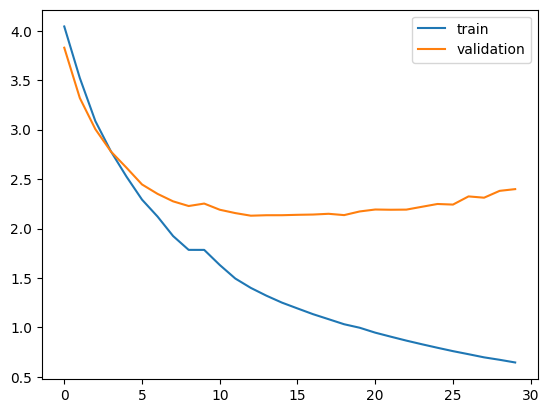

In [27]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

In [28]:
model = load_model('model_GUM_2_2.h1')

In [29]:
def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [30]:
def predict_sequence(model, tokenizer, source):
    prediction = model.predict(source, verbose=0)[0]
    integers = [argmax(vector) for vector in prediction]
    target = list()
    for i in integers:
        word = word_for_id(i, tokenizer)
        if word is None:
            break
        target.append(word)
    return ' '.join(target)

In [31]:
def evaluate_model(model, tokenizer, test, test_t):
    actual, predicted, bleu = list(), list(), list()
    for i, x in enumerate(test):
        x = x.reshape((1, x.shape[0]))
        translation = predict_sequence(model, tokenizer, x)
        predicted.append(translation.split())
    return predicted

In [32]:
eng_test[0]

array([    4,   339,   161,    17,     9,     1,    20, 12164,     0,
           0])

In [33]:
df_test.head(5)

,Unnamed: 0,eng,fr,info,eng_clean,fr_clean,eng_len,fr_len
163625,163625,The doctor told me that I was infertile.,Le docteur m'a appris que j'étais stérile.,CC-BY 2.0 (France) Attribution: tatoeba.org #10624837 (AlanF_US) & #8608350 (Aiji),the doctor told me that i was infertile,le docteur m a appris que j étais stérile,9,10
56766,56766,I hear someone singing.,J'entends quelqu'un qui chante.,CC-BY 2.0 (France) Attribution: tatoeba.org #5218768 (mailohilohi) & #6000357 (PERCE_NEIGE),i hear someone singing,j entends quelqu un qui chante,5,7
127042,127042,We ate sandwiches for breakfast.,Nous avons mangé des sandwichs pour le petit-déjeuner.,CC-BY 2.0 (France) Attribution: tatoeba.org #249073 (CK) & #567102 (sacredceltic),we ate sandwiches for breakfast,nous avons mangé des sandwichs pour le petit déjeuner,6,10
85372,85372,Both spellings are correct.,Les deux orthographes sont correctes.,CC-BY 2.0 (France) Attribution: tatoeba.org #547181 (darinmex) & #548926 (sacredceltic),both spellings are correct,les deux orthographes sont correctes,5,6
120014,120014,They're eating high on the hog.,Ils mènent grand train.,CC-BY 2.0 (France) Attribution: tatoeba.org #307703 (CM) & #1176349 (sacredceltic),they re eating high on the hog,ils mènent grand train,8,5


In [34]:
preds = evaluate_model(model, tokenizer_fr, eng_test, fr_test)

In [35]:
type(preds[0])

list

In [54]:
def bleu_score(orginal, translated):
    score = sentence_bleu([orginal], translated)
    return score

In [55]:
df_test['fr_preds'] = preds
df_test['fr_preds']=df_test.fr_preds.apply(lambda x: ' '.join(x))
df_test['bleu_score']=df_test.apply(lambda x: bleu_score(x.fr_clean, x.fr_preds), axis=1)

C:\Users\Weronika Gramacka\anaconda3\envs\python\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\Weronika Gramacka\anaconda3\envs\python\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\Weronika Gramacka\anaconda3\envs\python\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contain

In [56]:
df_test.head(5)

,Unnamed: 0,eng,fr,info,eng_clean,fr_clean,eng_len,fr_len,fr_preds,bleu_score
163625,163625,The doctor told me that I was infertile.,Le docteur m'a appris que j'étais stérile.,CC-BY 2.0 (France) Attribution: tatoeba.org #10624837 (AlanF_US) & #8608350 (Aiji),the doctor told me that i was infertile,le docteur m a appris que j étais stérile,9,10,le médecin m a dit pourquoi il subsiste,0.189627
56766,56766,I hear someone singing.,J'entends quelqu'un qui chante.,CC-BY 2.0 (France) Attribution: tatoeba.org #5218768 (mailohilohi) & #6000357 (PERCE_NEIGE),i hear someone singing,j entends quelqu un qui chante,5,7,j entends entendu le nom,0.371274
127042,127042,We ate sandwiches for breakfast.,Nous avons mangé des sandwichs pour le petit-déjeuner.,CC-BY 2.0 (France) Attribution: tatoeba.org #249073 (CK) & #567102 (sacredceltic),we ate sandwiches for breakfast,nous avons mangé des sandwichs pour le petit déjeuner,6,10,nous avons mangé des questions à déjeuner déjeuner,0.586359
85372,85372,Both spellings are correct.,Les deux orthographes sont correctes.,CC-BY 2.0 (France) Attribution: tatoeba.org #547181 (darinmex) & #548926 (sacredceltic),both spellings are correct,les deux orthographes sont correctes,5,6,les deux sont sont correctes,0.588937
120014,120014,They're eating high on the hog.,Ils mènent grand train.,CC-BY 2.0 (France) Attribution: tatoeba.org #307703 (CM) & #1176349 (sacredceltic),they re eating high on the hog,ils mènent grand train,8,5,ils sont en l,0.154118


In [60]:
### Średnia jakoś działania modelu dla zbioru testowego na podstawie metryki BLEU
score =  df_test["bleu_score"].mean()
score

0.4334499563860816